# Feature Engineering

[P8: Labelling Players and Feature Engineering](#p8)

[P9: Flattening To 1 Row Per Play](#p9)

In [1]:
import pandas as pd
import numpy as np
pd.set_option('max_columns', None)
import re
import seaborn as sns
sns.set(font_scale=1.5)
import matplotlib.pyplot as plt

# P8: Labelling Players and Feature Engineering <a id='p8'></a>

In [278]:
print('plays:',len(df['uniqueId'].unique()))
print('footballs:',len(df[df['off_def_ball']=='football']))

plays: 15963
footballs: 15963


In [279]:
# taking the position of the ball at each frame in order to engineer features

fbxy=df[df['off_def_ball']=='football'][['uniqueId','x_snap','y_snap','x_pass','y_pass','x_p5','y_p5','x_p10','y_p10']].reset_index(drop=True)
fbxy.columns=['uniqueId','ball_x_sn','ball_y_sn','ball_x_p','ball_y_p','ball_x_p5','ball_y_p5','ball_x_p10','ball_y_p10']
fbxy

,uniqueId,ball_x_sn,ball_y_sn,ball_x_p,ball_y_p,ball_x_p5,ball_y_p5,ball_x_p10,ball_y_p10
0,20180906000075,29.89,26.45,23.10,26.33,29.27,17.42,35.65,8.40
1,20180906000146,70.83,23.44,65.39,23.62,74.69,16.91,75.40,16.65
2,20180906000168,70.95,23.50,65.49,24.64,67.59,37.70,68.43,45.22
3,20180906000190,70.00,23.62,61.60,26.24,71.27,31.06,80.83,35.65
4,20180906000256,108.26,29.48,102.52,28.86,107.43,19.21,110.79,10.44
...,...,...,...,...,...,...,...,...,...
15958,20181230153794,34.79,26.89,27.96,25.63,40.54,28.90,48.62,29.85
15959,20181230153819,52.85,26.54,46.47,26.35,59.35,32.18,65.43,34.88
15960,20181230153969,72.46,29.31,65.99,27.51,81.32,26.00,93.52,25.03
15961,20181230154057,37.52,23.80,29.80,24.74,36.10,33.80,39.76,40.22


In [280]:
# engineered features of distances to the ball at each frame and across frames

df=pd.merge(df,fbxy,on='uniqueId')

# distances are measured as euclidean with pythagoras theorem

df['dist_ball_sn']=[(((df.x_snap[i]-df.ball_x_sn[i])**2)+((df.y_snap[i]-df.ball_y_sn[i])**2))**0.5 for i in range(len(df))]
df['dist_ball_p']=[(((df.x_pass[i]-df.ball_x_p[i])**2)+((df.y_pass[i]-df.ball_y_p[i])**2))**0.5 for i in range(len(df))]
df['dist_ball_p5']=[(((df.x_p5[i]-df.ball_x_p5[i])**2)+((df.y_p5[i]-df.ball_y_p5[i])**2))**0.5 for i in range(len(df))]
df['dist_ball_p10']=[(((df.x_p10[i]-df.ball_x_p10[i])**2)+((df.y_p10[i]-df.ball_y_p10[i])**2))**0.5 for i in range(len(df))]

In [281]:
# these features show whether players are moving closer to or further away from the ball at each frame

df['dist_ball_sn_p']=df.dist_ball_p-df.dist_ball_sn
df['dist_ball_p_p5']=df.dist_ball_p5-df.dist_ball_p
df['dist_ball_p5_p10']=df.dist_ball_p10-df.dist_ball_p5
df['dist_ball_p_p10']=df.dist_ball_p10-df.dist_ball_p

### PASSER

In [283]:
# in order to identify the passing player I am taking the offensive player closest to the ball at the pass frame

off=df[df['off_def_ball']=='offense']

passer=list(off.groupby('uniqueId')['dist_ball_p'].idxmin())

df['passer']=0
df['passer'].at[passer]=1

/Users/jamesgibbins/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [285]:
# in some instances the closest player is over 5 yards away from the ball - here I was unable to identify the passing player
unk_passer=list(df[(df['dist_ball_p']>=5)&(df['passer']==1)]['uniqueId'].unique())
len(unk_passer)

147

In [286]:
# drop plays where passer is unclear
df=df[~df['uniqueId'].isin(unk_passer)]

In [287]:
# as expected vast majority of passes are made by QBs
df[df['passer']==1].position.value_counts()

QB    15409
RB      276
TE       93
WR       27
FB        8
HB        3
Name: position, dtype: int64

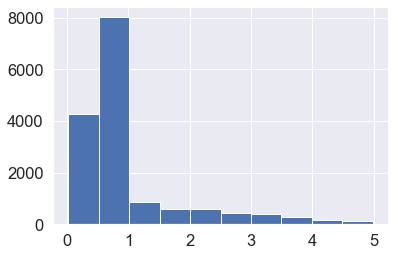

In [291]:
# majority of passers are within 1 yard of the ball at passing frame (as expected)
df[(df['passer']==1)]['dist_ball_p'].hist()
plt.show()

In [417]:
# 15816 frames have passers identified

In [288]:
len(df['uniqueId'].unique())

15816

In [289]:
len(df[df['off_def_ball']=='football'])

15816

In [290]:
len(df[df['passer']==1])

15816

### Receiver

In [416]:
# Intended receiver has been labelled on majority of plays by the kaggle competition organisers

rec=pd.read_csv('/Users/jamesgibbins/Desktop/DSI_capstone/nfl_big_data_bowl_2021_raw_data/targetedReceiver.csv')

In [294]:
rec['uniqueId']= rec.gameId*10000 + rec.playId

rec=rec[['uniqueId','targetNflId']]

In [295]:
df=df.merge(rec,on='uniqueId')

df['rec']=[1 if df.nflId[i]==df.targetNflId[i] else 0 for i in range(len(df))]

In [296]:
rxy=df[df['rec']==1][['uniqueId','x_snap','y_snap','x_pass','y_pass','x_p5','y_p5','x_p10','y_p10']].reset_index(drop=True)
rxy.columns=['uniqueId','rec_x_sn','rec_y_sn','rec_x_p','rec_y_p','rec_x_p5','rec_y_p5','rec_x_p10','rec_y_p10']
rxy

,uniqueId,rec_x_sn,rec_y_sn,rec_x_p,rec_y_p,rec_x_p5,rec_y_p5,rec_x_p10,rec_y_p10
0,20180906000075,28.64,9.16,39.31,8.39,39.77,7.38,39.05,5.81
1,20180906000146,69.95,15.26,74.49,16.39,75.21,16.51,74.47,16.32
2,20180906000168,68.52,32.87,68.17,39.61,68.57,41.37,68.42,42.48
3,20180906000190,69.61,31.72,84.30,32.23,87.62,33.92,90.56,36.65
4,20180906000256,107.70,21.01,110.83,18.10,111.12,15.21,111.10,11.99
...,...,...,...,...,...,...,...,...,...
15507,20181230153794,34.11,35.60,43.34,33.85,46.21,32.39,48.83,30.13
15508,20181230153819,52.35,35.60,66.51,35.92,66.17,35.64,65.69,34.97
15509,20181230153969,71.58,17.48,89.54,18.28,93.37,19.87,96.84,22.46
15510,20181230154057,33.87,26.57,38.62,32.58,39.48,35.88,39.96,39.54


In [ ]:
df=pd.merge(df,rxy,on='uniqueId')

df['dist_rec_sn']=[(((df.x_snap[i]-df.rec_x_sn[i])**2)+((df.y_snap[i]-df.rec_y_sn[i])**2))**0.5 for i in range(len(df))]
df['dist_rec_p']=[(((df.x_pass[i]-df.rec_x_p[i])**2)+((df.y_pass[i]-df.rec_y_p[i])**2))**0.5 for i in range(len(df))]
df['dist_rec_p5']=[(((df.x_p5[i]-df.rec_x_p5[i])**2)+((df.y_p5[i]-df.rec_y_p5[i])**2))**0.5 for i in range(len(df))]
df['dist_rec_p10']=[(((df.x_p10[i]-df.rec_x_p10[i])**2)+((df.y_p10[i]-df.rec_y_p10[i])**2))**0.5 for i in range(len(df))]

df['dist_rec_sn_p']=df.dist_rec_p-df.dist_rec_sn
df['dist_rec_p_p5']=df.dist_rec_p5-df.dist_rec_p
df['dist_rec_p5_p10']=df.dist_rec_p10-df.dist_rec_p5
df['dist_rec_p_p10']=df.dist_rec_p10-df.dist_rec_p

In [ ]:
df[df['rec']==1].position.value_counts()

In [ ]:
len(df.uniqueId.unique())

In [ ]:
df.passer.sum()

In [ ]:
df.rec.sum()

### Defender labels

In [320]:
counts=df.groupby(['uniqueId','off_def_ball'])[['displayName']].count().reset_index()

In [321]:
# only 1 play has less than 5 defenders tracked - I will be using data from the 5 defenders nearest the receiver at the ball snap.
counts[counts['off_def_ball']=='defense']['displayName'].value_counts()

7     8281
8     4047
9     2479
10     544
6       99
11      39
5       22
4        1
Name: displayName, dtype: int64

In [ ]:
df['def1']=0
df['def2']=0
df['def3']=0
df['def4']=0
df['def5']=0

In [ ]:
#labelling defenders 1 (closest to receiver) to 5 (5th closest to receiver)

defn=df[df['off_def_ball']=='defense']
not_def1=defn[defn['def1']==0]
not_def2=not_def1[not_def1['def2']==0]
not_def3=not_def2[not_def2['def3']==0]
not_def4=not_def3[not_def3['def4']==0]
not_def5=not_def4[not_def4['def5']==0]

In [ ]:
def1=list(defn.groupby('uniqueId')['dist_rec_sn'].idxmin())
df['def1'].at[def1]=1

In [ ]:
def2=list(not_def1.groupby('uniqueId')['dist_rec_sn'].idxmin())
df['def2'].at[def2]=1

In [ ]:
def3=list(not_def2.groupby('uniqueId')['dist_rec_sn'].idxmin())
df['def3'].at[def3]=1

In [ ]:
def4=list(not_def3.groupby('uniqueId')['dist_rec_sn'].idxmin())
df['def4'].at[def4]=1

In [ ]:
def5=list(not_def4.groupby('uniqueId')['dist_rec_sn'].idxmin())
df['def5'].at[def5]=1

### Defenders in 5 and 10 yard ranges

In [ ]:
# each of these features will be a dummy variable (1,0) dependent on if the defending players are within 5 / 10 yards of the receiver at each frame

df['10yd_rec_p']=[1 if df.dist_rec_p[i]<=10 else 0 for i in range(len(df))]
df['10yd_rec_p5']=[1 if df.dist_rec_p5[i]<=10 else 0 for i in range(len(df))] 
df['10yd_rec_p10']=[1 if df.dist_rec_p10[i]<=10 else 0 for i in range(len(df))]

df['5yd_rec_p']=[1 if df.dist_rec_p[i]<=5 else 0 for i in range(len(df))]
df['5yd_rec_p5']=[1 if df.dist_rec_p5[i]<=5 else 0 for i in range(len(df))] 
df['5yd_rec_p10']=[1 if df.dist_rec_p10[i]<=5 else 0 for i in range(len(df))]

df['5yd_ball_p']=[1 if df.dist_ball_p[i]<=5 else 0 for i in range(len(df))]
df['10yd_ball_p']=[1 if df.dist_ball_p[i]<=10 else 0 for i in range(len(df))] 

### Defender direction / orientation with respect to receiver

In [500]:
# by making use of arctan2 we are able to express the orientation ('o') and direction ('dir') of each defender relative to the position of the receiver for each frame. 

# in the example below we take the receiver coordinates and a defenders coordinates at p10 frame and describe the angle of an imaginary line drawn between them in the same 
# reference as orientation and direction is given (0 degrees parallel to y axis of the field)

# here we see the defenders actual orientation and direction are within 18 degrees of the true angle between himself and receiver at frame p10

x = df.rec_x_p10[0] - df.x_p10[0]
y = df.rec_y_p10[0] - df.y_p10[0]

print('true angle:' ,(90 - np.arctan2(y,x) * (180/np.pi)) %360)

print('actual direction:', df.dir_p10[0])
print('actual orientation:', df.o_p10[0])

true angle: 154.1152097537905
actual direction: 172.31
actual orientation: 170.88


In [ ]:
df['dir_rec_p']=[np.abs(((90 - np.arctan2((df.rec_y_p[i] - df.y_pass[i]),(df.rec_x_p[i] - df.x_pass[i])) * (180/np.pi)) %360) - df.dir_pass[i])  for i in range(len(df))]
df['dir_rec_p5']=[np.abs(((90 - np.arctan2((df.rec_y_p5[i] - df.y_p5[i]),(df.rec_x_p5[i] - df.x_p5[i])) * (180/np.pi)) %360) - df.dir_p5[i])  for i in range(len(df))]
df['dir_rec_p10']=[np.abs(((90 - np.arctan2((df.rec_y_p10[i] - df.y_p10[i]),(df.rec_x_p10[i] - df.x_p10[i])) * (180/np.pi)) %360) - df.dir_p10[i])  for i in range(len(df))]

df['o_rec_p']=[np.abs(((90 - np.arctan2((df.rec_y_p[i] - df.y_pass[i]),(df.rec_x_p[i] - df.x_pass[i])) * (180/np.pi)) %360) - df.o_pass[i])  for i in range(len(df))]
df['o_rec_p5']=[np.abs(((90 - np.arctan2((df.rec_y_p5[i] - df.y_p5[i]),(df.rec_x_p5[i] - df.x_p5[i])) * (180/np.pi)) %360) - df.o_p5[i])  for i in range(len(df))]
df['o_rec_p10']=[np.abs(((90 - np.arctan2((df.rec_y_p10[i] - df.y_p10[i]),(df.rec_x_p10[i] - df.x_p10[i])) * (180/np.pi)) %360) - df.o_p10[i])  for i in range(len(df))]

In [ ]:
df.to_csv(r'/Users/jamesgibbins/Desktop/DSI_capstone/capstone_data/sn_pass_p5_p10_flat_labelled.csv', index=False)

# P8: Summary

- Feature Engineering involved the labelling of certain players on the play , namely: Passer & Receiver for the offense and Defenders 1-5 for the defense
- Once labelled - I have engineered features that relate each players movements with relation to the ball and receiver over the 4 frames
- In some cases I was unable to clearly identify the passing player - these plays were dropped

# P9: Flattening To 1 Row Per Play <a id='p9'></a>

In [298]:
df=pd.read_csv('/Users/jamesgibbins/Desktop/DSI_capstone/capstone_data/sn_pass_p5_p10_flat_labelled.csv')

In [224]:
pl_stats=players[['nflId','height','weight','age']]

In [225]:
features=plays

In [226]:
features.drop(['playDescription','gameId','playId','gameDate','gameTimeET','gameClock','absoluteYardlineNumber','passResult','offensePlayResult','playResult','epa'], axis=1, inplace=True)

In [227]:
df.columns[:55]

Index(['uniqueId', 'gameId', 'playId', 'week', 'playDirection', 'lineScrim',
       'nflId', 'displayName', 'position', 'team', 'home_away', 'off_def_ball',
       'ball', 'route', 'frameId_snap', 'event_snap', 'x_snap', 'y_snap',
       's_snap', 'a_snap', 'dis_snap', 'o_snap', 'dir_snap', 'frameId_pass',
       'event_pass', 'x_pass', 'y_pass', 's_pass', 'a_pass', 'dis_pass',
       'o_pass', 'dir_pass', 'frameId_p5', 'event_p5', 'x_p5', 'y_p5', 's_p5',
       'a_p5', 'dis_p5', 'o_p5', 'dir_p5', 'frameId_p10', 'event_p10', 'x_p10',
       'y_p10', 's_p10', 'a_p10', 'dis_p10', 'o_p10', 'dir_p10', 'ball_x_sn',
       'ball_y_sn', 'ball_x_p', 'ball_y_p', 'ball_x_p5'],
      dtype='object')

In [228]:
df.columns[55:110]

Index(['ball_y_p5', 'ball_x_p10', 'ball_y_p10', 'dist_ball_sn', 'dist_ball_p',
       'dist_ball_p5', 'dist_ball_p10', 'dist_ball_sn_p', 'dist_ball_p_p5',
       'dist_ball_p5_p10', 'dist_ball_p_p10', 'passer', 'targetNflId', 'rec',
       'rec_x_sn', 'rec_y_sn', 'rec_x_p', 'rec_y_p', 'rec_x_p5', 'rec_y_p5',
       'rec_x_p10', 'rec_y_p10', 'dist_rec_sn', 'dist_rec_p', 'dist_rec_p5',
       'dist_rec_p10', 'dist_rec_sn_p', 'dist_rec_p_p5', 'dist_rec_p5_p10',
       'dist_rec_p_p10', 'def1', 'def2', 'def3', 'def4', 'def5', 'def6',
       'def7', 'def8', 'def9', 'def10', 'def11', '10yd_rec_p', '10yd_rec_p5',
       '10yd_rec_p10', '5yd_rec_p', '5yd_rec_p5', '5yd_rec_p10', '5yd_ball_p',
       '10yd_ball_p', 'dir_rec_p10', 'dir_rec_p', 'dir_rec_p5', 'o_rec_p',
       'o_rec_p5', 'o_rec_p10'],
      dtype='object')

In [229]:
inf=df.groupby('uniqueId')[['frameId_snap','frameId_pass','lineScrim']].mean().reset_index()

inf['snap2pass']=(inf['frameId_pass'] - inf['frameId_snap']) /10

inf

,uniqueId,frameId_snap,frameId_pass,lineScrim,snap2pass
0,20180906000075,11,36,30.0,2.5
1,20180906000146,11,31,71.0,2.0
2,20180906000168,11,34,71.0,2.3
3,20180906000190,11,39,71.0,2.8
4,20180906000256,11,31,109.0,2.0
...,...,...,...,...,...
15507,20181230153794,11,36,35.0,2.5
15508,20181230153819,11,42,53.0,3.1
15509,20181230153969,11,45,73.0,3.4
15510,20181230154057,11,37,39.0,2.6


In [230]:
features=inf[['uniqueId','lineScrim','snap2pass']].merge(features, on='uniqueId')

In [303]:
rec=df[(df['rec']==1)][['uniqueId','nflId','position','route','x_snap', 'y_snap', 's_snap', 'a_snap',
       'dis_snap', 'o_snap', 'dir_snap', 'x_pass', 'y_pass', 's_pass',
       'a_pass', 'dis_pass', 'o_pass', 'dir_pass', 'x_p5', 'y_p5', 's_p5',
       'a_p5', 'dis_p5', 'o_p5', 'dir_p5', 'x_p10', 'y_p10', 's_p10', 'a_p10',
       'dis_p10', 'o_p10', 'dir_p10','dist_ball_sn','dist_ball_p','dist_ball_p5','dist_ball_p10','dist_ball_p5_p10', 'dist_ball_p_p10']]

rec=rec.merge(pl_stats, on='nflId')

rec_cols=['uniqueId']+['rec_'+i for i in list(rec.columns[1:])]
rec.columns=rec_cols

In [304]:
rec

,uniqueId,rec_nflId,rec_position,rec_route,rec_x_snap,rec_y_snap,rec_s_snap,rec_a_snap,rec_dis_snap,rec_o_snap,rec_dir_snap,rec_x_pass,rec_y_pass,rec_s_pass,rec_a_pass,rec_dis_pass,rec_o_pass,rec_dir_pass,rec_x_p5,rec_y_p5,rec_s_p5,rec_a_p5,rec_dis_p5,rec_o_p5,rec_dir_p5,rec_x_p10,rec_y_p10,rec_s_p10,rec_a_p10,rec_dis_p10,rec_o_p10,rec_dir_p10,rec_dist_ball_sn,rec_dist_ball_p,rec_dist_ball_p5,rec_dist_ball_p10,rec_dist_ball_p5_p10,rec_dist_ball_p_p10,rec_height,rec_weight,rec_age
0,20180906000075,2495454.0,WR,HITCH,28.64,9.16,0.00,0.01,0.02,109.53,229.86,39.31,8.39,3.11,6.67,0.34,335.11,117.88,39.77,7.38,2.56,4.82,0.25,296.51,193.02,39.05,5.81,4.05,1.42,0.40,249.74,205.26,17.335126,24.178662,14.527615,4.274120,-10.253495,-19.904542,75,220,30
1,20180906000190,2495454.0,WR,CORNER,69.61,31.72,0.00,0.00,0.01,87.82,3.67,84.30,32.23,7.32,4.19,0.73,35.00,72.39,87.62,33.92,7.67,3.23,0.76,315.56,55.20,90.56,36.65,8.18,2.48,0.82,306.46,41.50,8.109383,23.477012,16.598256,9.781252,-6.817003,-13.695760,75,220,30
2,20180906000889,2495454.0,WR,POST,28.63,44.87,0.00,0.00,0.01,99.80,353.06,40.13,37.69,7.31,3.84,0.73,228.29,156.37,41.37,34.14,7.52,0.91,0.76,236.29,163.16,42.48,30.57,7.11,2.09,0.71,201.37,161.78,15.449926,18.714513,9.434644,0.832166,-8.602478,-17.882347,75,220,30
3,20180906001423,2495454.0,WR,OUT,36.21,38.61,0.01,0.01,0.02,88.47,69.27,58.79,41.09,5.47,6.87,0.57,71.17,64.13,60.45,43.22,5.79,5.80,0.57,340.58,19.42,60.82,46.15,5.80,3.01,0.59,288.02,357.80,14.738826,33.888176,24.342483,15.424724,-8.917760,-18.463453,75,220,30
4,20180906001869,2495454.0,WR,OUT,19.85,17.77,0.02,0.68,0.02,72.00,102.53,30.53,12.99,6.98,4.71,0.71,198.60,129.52,32.63,10.35,6.82,4.96,0.68,249.08,154.42,33.55,7.13,6.45,3.34,0.65,269.02,172.17,12.255338,24.105280,15.019041,8.298078,-6.720963,-15.807201,75,220,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15507,20181230120400,2561359.0,WR,HITCH,35.57,8.72,0.00,0.06,0.01,88.15,83.75,52.71,2.20,3.60,1.48,0.37,290.42,213.39,51.85,0.90,2.68,1.71,0.28,284.54,212.82,51.33,-0.18,2.14,1.34,0.22,250.93,199.27,20.634907,31.927125,18.574488,6.587511,-11.986977,-25.339614,72,180,23
15508,20181230123412,2561359.0,WR,OUT,52.82,19.83,0.05,0.05,0.01,81.00,117.48,60.17,11.18,4.82,3.28,0.50,329.84,149.77,60.99,9.07,4.33,2.13,0.44,314.90,167.00,61.41,6.88,4.59,0.04,0.46,289.02,169.76,9.829451,22.182123,10.635234,2.870139,-7.765095,-19.311984,72,180,23
15509,20181230123320,2561329.0,TE,HITCH,38.20,29.27,0.00,0.00,0.01,114.74,85.14,44.52,30.64,3.82,4.49,0.39,327.81,46.26,45.43,32.21,3.56,2.01,0.36,254.02,19.47,46.33,33.40,2.81,3.75,0.28,172.60,57.45,4.851031,13.004030,3.043567,0.341321,-2.702246,-12.662709,78,265,23
15510,20181230131861,2559485.0,WR,POST,58.32,31.90,0.19,1.48,0.02,77.27,60.70,81.94,35.52,8.75,0.71,0.88,150.27,101.30,86.32,34.73,8.94,1.02,0.90,141.53,99.05,90.86,34.03,9.20,0.76,0.93,151.08,98.73,8.905785,31.058920,24.581662,18.618542,-5.963120,-12.440378,72,198,24


In [233]:
features=features.merge(rec, on='uniqueId')

In [402]:
passer=df[(df['passer']==1)][['uniqueId','nflId','position','x_snap', 'y_snap', 's_snap', 'a_snap',
       'dis_snap', 'o_snap', 'dir_snap', 'x_pass', 'y_pass', 's_pass',
       'a_pass', 'dis_pass', 'o_pass', 'dir_pass', 'x_p5', 'y_p5', 's_p5',
       'a_p5', 'dis_p5', 'o_p5', 'dir_p5', 'x_p10', 'y_p10', 's_p10', 'a_p10',
       'dis_p10', 'o_p10', 'dir_p10','dist_ball_sn','dist_ball_p','dist_ball_p5','dist_ball_p10','dist_rec_p']]

passer=passer.merge(pl_stats, on='nflId')

passer.columns=['uniqueId']+['passer_'+i for i in list(passer.columns[1:])]

In [403]:
passer

,uniqueId,passer_nflId,passer_position,passer_x_snap,passer_y_snap,passer_s_snap,passer_a_snap,passer_dis_snap,passer_o_snap,passer_dir_snap,passer_x_pass,passer_y_pass,passer_s_pass,passer_a_pass,passer_dis_pass,passer_o_pass,passer_dir_pass,passer_x_p5,passer_y_p5,passer_s_p5,passer_a_p5,passer_dis_p5,passer_o_p5,passer_dir_p5,passer_x_p10,passer_y_p10,passer_s_p10,passer_a_p10,passer_dis_p10,passer_o_p10,passer_dir_p10,passer_dist_ball_sn,passer_dist_ball_p,passer_dist_ball_p5,passer_dist_ball_p10,passer_dist_rec_p,passer_height,passer_weight,passer_age
0,20180906000075,310.0,QB,28.26,26.63,0.00,0.00,0.01,97.41,55.01,23.57,26.52,0.84,2.05,0.08,176.40,153.39,23.76,26.16,0.69,1.38,0.07,135.32,168.39,23.70,25.84,0.60,0.20,0.06,147.57,194.87,1.639909,0.506952,10.331878,21.141336,24.009259,76,217,33
1,20180906000146,310.0,QB,69.39,23.59,0.00,0.00,0.01,87.52,351.48,66.12,23.58,0.46,2.25,0.04,155.30,176.66,66.10,23.40,0.26,1.07,0.02,134.68,230.88,65.82,23.46,0.83,0.82,0.08,140.40,289.70,1.447791,0.731095,10.766067,11.753829,11.034174,76,217,33
2,20180906000168,310.0,QB,65.44,23.63,0.00,0.00,0.00,97.89,94.70,64.89,24.59,1.65,0.48,0.17,70.68,334.41,64.67,25.18,0.98,1.21,0.10,340.81,347.39,64.62,25.62,0.82,0.31,0.08,348.24,358.98,5.511533,0.602080,12.856002,19.966875,15.373965,76,217,33
3,20180906000190,310.0,QB,65.83,23.69,0.03,0.38,0.00,106.54,247.43,61.89,26.78,2.38,0.91,0.24,80.91,359.38,61.89,27.65,1.11,2.39,0.12,30.52,2.85,61.99,27.97,0.44,1.06,0.05,3.71,46.08,4.170587,0.612944,9.980606,20.345221,23.063187,76,217,33
4,20180906000256,310.0,QB,104.13,29.82,0.09,0.10,0.01,106.80,106.09,103.03,29.24,0.90,0.50,0.09,176.00,175.19,102.90,28.82,0.98,1.58,0.09,142.31,222.14,102.30,28.46,1.80,1.25,0.18,178.26,245.57,4.143972,0.636003,10.624171,19.919852,13.599250,76,217,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15507,20181230080372,2553743.0,RB,57.92,21.35,0.00,0.00,0.00,92.90,227.49,54.52,22.41,0.80,3.60,0.09,148.76,3.53,54.80,22.23,1.63,3.39,0.15,191.44,147.65,55.32,21.10,3.18,1.76,0.31,280.16,158.04,4.992645,0.542310,11.362121,20.916673,19.032301,75,236,27
15508,20181230102564,2533040.0,WR,102.96,37.33,0.00,0.00,0.00,101.82,330.15,94.01,26.61,5.52,1.44,0.56,175.50,199.55,92.84,24.15,5.27,1.62,0.54,189.05,209.05,91.38,21.85,5.45,0.57,0.55,193.31,213.79,13.541909,0.818352,7.918365,14.874280,13.093987,74,215,29
15509,20181230143534,2552576.0,QB,56.63,29.53,0.00,0.00,0.01,84.75,98.86,51.79,30.98,2.74,0.93,0.28,28.53,307.85,50.67,31.94,3.07,0.44,0.31,2.93,313.44,49.67,33.04,2.88,1.11,0.29,9.55,323.17,4.220296,0.555428,7.127692,9.827741,7.471359,78,231,26
15510,20181230143603,2552576.0,QB,72.24,23.71,0.03,0.04,0.03,86.58,222.13,67.34,23.33,3.04,0.93,0.31,165.50,239.85,66.04,22.66,2.75,1.50,0.28,181.51,249.22,64.91,22.34,1.94,1.66,0.20,197.94,256.56,3.450232,0.352278,9.284078,12.351619,7.623674,78,231,26


In [235]:
features=features.merge(passer, on='uniqueId')

In [300]:
def1=df[(df['def1']==1)][['uniqueId','nflId','position','x_snap', 'y_snap', 's_snap', 'a_snap',
       'dis_snap', 'o_snap', 'dir_snap', 'x_pass', 'y_pass', 's_pass',
       'a_pass', 'dis_pass', 'o_pass', 'dir_pass', 'x_p5', 'y_p5', 's_p5',
       'a_p5', 'dis_p5', 'o_p5', 'dir_p5', 'x_p10', 'y_p10', 's_p10', 'a_p10',
       'dis_p10', 'o_p10', 'dir_p10','dist_ball_sn','dist_ball_p','dist_ball_p5','dist_ball_p10',
           'dist_rec_sn','dist_rec_p','dist_rec_p5','dist_rec_p10','10yd_rec_p', '10yd_rec_p5',
       '10yd_rec_p10', '5yd_rec_p', '5yd_rec_p5', '5yd_rec_p10', '5yd_ball_p',
       '10yd_ball_p', 'dir_rec_p10', 'dir_rec_p', 'dir_rec_p5', 'o_rec_p',
       'o_rec_p5', 'o_rec_p10']]

def1=def1.merge(pl_stats, on='nflId')

def1.columns=['uniqueId']+['def1_'+i for i in list(def1.columns[1:])]

In [301]:
def1

,uniqueId,def1_nflId,def1_position,def1_x_snap,def1_y_snap,def1_s_snap,def1_a_snap,def1_dis_snap,def1_o_snap,def1_dir_snap,def1_x_pass,def1_y_pass,def1_s_pass,def1_a_pass,def1_dis_pass,def1_o_pass,def1_dir_pass,def1_x_p5,def1_y_p5,def1_s_p5,def1_a_p5,def1_dis_p5,def1_o_p5,def1_dir_p5,def1_x_p10,def1_y_p10,def1_s_p10,def1_a_p10,def1_dis_p10,def1_o_p10,def1_dir_p10,def1_dist_ball_sn,def1_dist_ball_p,def1_dist_ball_p5,def1_dist_ball_p10,def1_dist_rec_sn,def1_dist_rec_p,def1_dist_rec_p5,def1_dist_rec_p10,def1_10yd_rec_p,def1_10yd_rec_p5,def1_10yd_rec_p10,def1_5yd_rec_p,def1_5yd_rec_p5,def1_5yd_rec_p10,def1_5yd_ball_p,def1_10yd_ball_p,def1_dir_rec_p10,def1_dir_rec_p,def1_dir_rec_p5,def1_o_rec_p,def1_o_rec_p5,def1_o_rec_p10,def1_height,def1_weight,def1_age
0,20180906000075,2555383.0,CB,36.08,9.86,0.06,0.05,0.02,279.77,48.90,43.47,8.37,4.68,2.18,0.47,2.14,97.48,45.24,7.88,2.80,5.70,0.30,295.28,122.92,45.67,6.57,3.66,5.29,0.34,252.88,187.30,17.707179,27.156924,18.602486,10.185740,7.472858,4.160048,5.492804,6.663483,1,1,1,1,0,0,0,0,76.150908,172.795458,141.857240,268.135458,30.502760,10.570908,72,191,24
1,20180906002474,2555383.0,CB,48.22,11.75,2.49,0.52,0.25,290.52,90.07,58.56,7.03,3.60,4.79,0.34,55.33,91.38,61.05,6.91,6.10,3.06,0.59,93.76,93.29,64.53,6.71,7.64,1.32,0.75,95.59,93.52,19.650112,31.812061,23.206898,16.683657,7.595183,2.223263,2.518293,2.711900,1,1,1,1,1,1,0,0,32.164183,72.211575,46.680991,36.161575,47.150991,34.234183,72,191,24
2,20180906003507,2555383.0,CB,88.61,11.72,0.03,0.04,0.06,278.10,27.02,101.99,11.93,3.86,5.23,0.39,137.97,103.87,103.43,10.51,4.81,6.03,0.47,199.55,156.03,103.69,8.26,3.88,5.95,0.40,244.99,194.35,13.081170,28.445942,19.333225,10.065237,6.673230,4.430011,4.765428,4.434636,1,1,1,1,1,1,0,0,80.306346,166.000664,106.979200,131.900664,63.459200,29.666346,72,191,24
3,20180916060051,2555383.0,CB,43.11,12.47,0.09,0.25,0.01,311.92,42.44,52.72,11.25,6.74,1.21,0.67,32.12,91.39,56.38,11.48,7.76,2.08,0.77,37.04,82.24,60.37,12.43,8.50,2.24,0.85,34.75,71.90,18.801798,30.233023,23.230984,17.546740,9.973209,2.777517,2.004196,1.884808,1,1,1,1,1,1,0,0,256.771307,198.610731,223.829410,257.880731,269.029410,293.921307,72,191,24
4,20180916062529,2555383.0,CB,109.05,11.14,0.62,2.39,0.05,251.62,78.64,112.11,14.17,5.76,4.03,0.55,325.14,8.92,112.82,17.50,7.49,1.95,0.74,356.18,15.39,114.70,20.72,7.31,4.44,0.71,33.01,38.92,15.968074,13.463321,2.144015,1.760710,4.899796,1.162970,1.069626,1.205985,1,1,1,1,1,1,0,0,56.790593,339.673447,26.199055,23.453447,314.590945,62.700593,72,191,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15507,20181230084224,2552427.0,CB,45.17,10.01,0.73,1.19,0.07,276.83,75.82,53.42,8.96,1.61,5.49,0.18,327.53,76.79,53.22,9.28,2.19,4.82,0.19,309.51,293.46,51.84,9.90,3.50,0.91,0.35,301.06,295.80,15.251062,25.703113,10.436575,2.696998,7.235040,4.165405,3.650151,2.223016,1,1,1,1,1,1,0,0,1.802487,215.649990,1.841379,35.090010,14.208621,3.457513,74,192,26
15508,20181230084412,2552427.0,CB,88.77,10.00,0.40,0.29,0.05,264.47,29.14,96.09,8.55,4.60,5.04,0.46,194.12,141.24,96.65,6.28,5.26,5.92,0.52,224.41,186.62,95.47,3.62,6.23,4.40,0.62,251.99,216.92,15.523289,28.177660,20.646997,13.740779,7.242189,1.982978,1.328345,0.783901,1,1,1,1,1,1,0,0,82.915539,104.650825,73.846767,51.770825,36.056767,47.845539,74,192,26
15509,20181230121314,2553710.0,SS,70.41,30.13,0.12,0.02,0.03,276.96,39.33,76.00,35.56,5.46,3.41,0.54,95.98,86.09,78.96,35.13,6.52,3.50,0.64,142.60,108.04,81.94,33.68,6.46,3.19,0.65,170.41,123.49,6.813648,18.661471,16.054460,15.283197,3.466208,14.558108,16.185407,15.701624,0,0,0,0,0,0,0,0,86.422346,110.390602,94.675172,100.500602,60.115172,39.502346,72,203,27
15510,20181230122241,2561003.0,LB,46.03,28.35,0.04,0.12,0.01,232.61,97.32,45.68,25.05,2.18,0.73,0.22,233.50,241.70,44.66,24.47,2.29,0.55,0.23,197.84,238.83,44.08,24.04,0.79,2.

In [308]:
features=features.merge(def1, on='uniqueId')

In [310]:
def2=df[(df['def2']==1)][['uniqueId','nflId','position','x_snap', 'y_snap', 's_snap', 'a_snap',
       'dis_snap', 'o_snap', 'dir_snap', 'x_pass', 'y_pass', 's_pass',
       'a_pass', 'dis_pass', 'o_pass', 'dir_pass', 'x_p5', 'y_p5', 's_p5',
       'a_p5', 'dis_p5', 'o_p5', 'dir_p5', 'x_p10', 'y_p10', 's_p10', 'a_p10',
       'dis_p10', 'o_p10', 'dir_p10','dist_ball_sn','dist_ball_p','dist_ball_p5','dist_ball_p10',
           'dist_rec_sn','dist_rec_p','dist_rec_p5','dist_rec_p10','10yd_rec_p', '10yd_rec_p5',
       '10yd_rec_p10', '5yd_rec_p', '5yd_rec_p5', '5yd_rec_p10', '5yd_ball_p',
       '10yd_ball_p', 'dir_rec_p10', 'dir_rec_p', 'dir_rec_p5', 'o_rec_p',
       'o_rec_p5', 'o_rec_p10']]

def2=def2.merge(pl_stats, on='nflId')

def2.columns=['uniqueId']+['def2_'+i for i in list(def2.columns[1:])]

In [311]:
features=features.merge(def2, on='uniqueId')

In [312]:
def3=df[(df['def3']==1)][['uniqueId','nflId','position','x_snap', 'y_snap', 's_snap', 'a_snap',
       'dis_snap', 'o_snap', 'dir_snap', 'x_pass', 'y_pass', 's_pass',
       'a_pass', 'dis_pass', 'o_pass', 'dir_pass', 'x_p5', 'y_p5', 's_p5',
       'a_p5', 'dis_p5', 'o_p5', 'dir_p5', 'x_p10', 'y_p10', 's_p10', 'a_p10',
       'dis_p10', 'o_p10', 'dir_p10','dist_ball_sn','dist_ball_p','dist_ball_p5','dist_ball_p10',
           'dist_rec_sn','dist_rec_p','dist_rec_p5','dist_rec_p10','10yd_rec_p', '10yd_rec_p5',
       '10yd_rec_p10', '5yd_rec_p', '5yd_rec_p5', '5yd_rec_p10', '5yd_ball_p',
       '10yd_ball_p', 'dir_rec_p10', 'dir_rec_p', 'dir_rec_p5', 'o_rec_p',
       'o_rec_p5', 'o_rec_p10']]

def3=def3.merge(pl_stats, on='nflId')

def3.columns=['uniqueId']+['def3_'+i for i in list(def3.columns[1:])]

In [313]:
features=features.merge(def3, on='uniqueId')

In [314]:
def4=df[(df['def4']==1)][['uniqueId','nflId','position','x_snap', 'y_snap', 's_snap', 'a_snap',
       'dis_snap', 'o_snap', 'dir_snap', 'x_pass', 'y_pass', 's_pass',
       'a_pass', 'dis_pass', 'o_pass', 'dir_pass', 'x_p5', 'y_p5', 's_p5',
       'a_p5', 'dis_p5', 'o_p5', 'dir_p5', 'x_p10', 'y_p10', 's_p10', 'a_p10',
       'dis_p10', 'o_p10', 'dir_p10','dist_ball_sn','dist_ball_p','dist_ball_p5','dist_ball_p10',
           'dist_rec_sn','dist_rec_p','dist_rec_p5','dist_rec_p10','10yd_rec_p', '10yd_rec_p5',
       '10yd_rec_p10', '5yd_rec_p', '5yd_rec_p5', '5yd_rec_p10', '5yd_ball_p',
       '10yd_ball_p', 'dir_rec_p10', 'dir_rec_p', 'dir_rec_p5', 'o_rec_p',
       'o_rec_p5', 'o_rec_p10']]

def4=def4.merge(pl_stats, on='nflId')

def4.columns=['uniqueId']+['def4_'+i for i in list(def4.columns[1:])]

In [315]:
features=features.merge(def4, on='uniqueId')

In [316]:
def5=df[(df['def5']==1)][['uniqueId','nflId','position','x_snap', 'y_snap', 's_snap', 'a_snap',
       'dis_snap', 'o_snap', 'dir_snap', 'x_pass', 'y_pass', 's_pass',
       'a_pass', 'dis_pass', 'o_pass', 'dir_pass', 'x_p5', 'y_p5', 's_p5',
       'a_p5', 'dis_p5', 'o_p5', 'dir_p5', 'x_p10', 'y_p10', 's_p10', 'a_p10',
       'dis_p10', 'o_p10', 'dir_p10','dist_ball_sn','dist_ball_p','dist_ball_p5','dist_ball_p10',
           'dist_rec_sn','dist_rec_p','dist_rec_p5','dist_rec_p10','10yd_rec_p', '10yd_rec_p5',
       '10yd_rec_p10', '5yd_rec_p', '5yd_rec_p5', '5yd_rec_p10', '5yd_ball_p',
       '10yd_ball_p', 'dir_rec_p10', 'dir_rec_p', 'dir_rec_p5', 'o_rec_p',
       'o_rec_p5', 'o_rec_p10']]

def5=def5.merge(pl_stats, on='nflId')

def5.columns=['uniqueId']+['def5_'+i for i in list(def5.columns[1:])]

In [317]:
features=features.merge(def5, on='uniqueId')

In [318]:
features

,uniqueId,lineScrim,snap2pass,week,home,away,offenseTeam,defenseTeam,preSnapHomeScore,preSnapVisitorScore,home_lead,off_lead,secRemQu,quarter,down,yardsToGo,offenseFormation,off_TE,off_WR,off_OL,off_QB,off_DL,off_DB,typeDropback,defendersInTheBox,numberOfPassRushers,def_DL,def_LB,def_DB,def_TE,def_OL,def_WR,rec_nflId,rec_position,rec_route,rec_x_snap,rec_y_snap,rec_s_snap,rec_a_snap,rec_dis_snap,rec_o_snap,rec_dir_snap,rec_x_pass,rec_y_pass,rec_s_pass,rec_a_pass,rec_dis_pass,rec_o_pass,rec_dir_pass,rec_x_p5,rec_y_p5,rec_s_p5,rec_a_p5,rec_dis_p5,rec_o_p5,rec_dir_p5,rec_x_p10,rec_y_p10,rec_s_p10,rec_a_p10,rec_dis_p10,rec_o_p10,rec_dir_p10,rec_dist_ball_sn,rec_dist_ball_p,rec_dist_ball_p5,rec_dist_ball_p10,rec_dist_ball_p5_p10,rec_dist_ball_p_p10,rec_height,rec_weight,rec_age,passer_nflId,passer_position,passer_route,passer_x_snap,passer_y_snap,passer_s_snap,passer_a_snap,passer_dis_snap,passer_o_snap,passer_dir_snap,passer_x_pass,passer_y_pass,passer_s_pass,passer_a_pass,passer_dis_pass,passer_o_pass,passer_dir_pass,passer_x_p5,passer_y_p5,passer_s_p5,passer_a_p5,passer_dis_p5,passer_o_p5,passer_dir_p5,passer_x_p10,passer_y_p10,passer_s_p10,passer_a_p10,passer_dis_p10,passer_o_p10,passer_dir_p10,passer_dist_ball_sn,passer_dist_ball_p,passer_dist_ball_p5,passer_dist_ball_p10,passer_dist_rec_p,passer_height,passer_weight,passer_age,def1_nflId,def1_position,def1_x_snap,def1_y_snap,def1_s_snap,def1_a_snap,def1_dis_snap,def1_o_snap,def1_dir_snap,def1_x_pass,def1_y_pass,def1_s_pass,def1_a_pass,def1_dis_pass,def1_o_pass,def1_dir_pass,def1_x_p5,def1_y_p5,def1_s_p5,def1_a_p5,def1_dis_p5,def1_o_p5,def1_dir_p5,def1_x_p10,def1_y_p10,def1_s_p10,def1_a_p10,def1_dis_p10,def1_o_p10,def1_dir_p10,def1_dist_ball_sn,def1_dist_ball_p,def1_dist_ball_p5,def1_dist_ball_p10,def1_dist_rec_sn,def1_dist_rec_p,def1_dist_rec_p5,def1_dist_rec_p10,def1_10yd_rec_p,def1_10yd_rec_p5,def1_10yd_rec_p10,def1_5yd_rec_p,def1_5yd_rec_p5,def1_5yd_rec_p10,def1_5yd_ball_p,def1_10yd_ball_p,def1_dir_rec_p10,def1_dir_rec_p,def1_dir_rec_p5,def1_o_rec_p,def1_o_rec_p5,def1_o_rec_p10,def1_height,def1_weight,def1_age,def2_nflId,def2_position,def2_x_snap,def2_y_snap,def2_s_snap,def2_a_snap,def2_dis_snap,def2_o_snap,def2_dir_snap,def2_x_pass,def2_y_pass,def2_s_pass,def2_a_pass,def2_dis_pass,def2_o_pass,def2_dir_pass,def2_x_p5,def2_y_p5,def2_s_p5,def2_a_p5,def2_dis_p5,def2_o_p5,def2_dir_p5,def2_x_p10,def2_y_p10,def2_s_p10,def2_a_p10,def2_dis_p10,def2_o_p10,def2_dir_p10,def2_dist_ball_sn,def2_dist_ball_p,def2_dist_ball_p5,def2_dist_ball_p10,def2_dist_rec_sn,def2_dist_rec_p,def2_dist_rec_p5,def2_dist_rec_p10,def2_10yd_rec_p,def2_10yd_rec_p5,def2_10yd_rec_p10,def2_5yd_rec_p,def2_5yd_rec_p5,def2_5yd_rec_p10,def2_5yd_ball_p,def2_10yd_ball_p,def2_dir_rec_p10,def2_dir_rec_p,def2_dir_rec_p5,def2_o_rec_p,def2_o_rec_p5,def2_o_rec_p10,def2_height,def2_weight,def2_age,def3_nflId,def3_position,def3_x_snap,def3_y_snap,def3_s_snap,def3_a_snap,def3_dis_snap,def3_o_snap,def3_dir_snap,def3_x_pass,def3_y_pass,def3_s_pass,def3_a_pass,def3_dis_pass,def3_o_pass,def3_dir_pass,def3_x_p5,def3_y_p5,def3_s_p5,def3_a_p5,def3_dis_p5,def3_o_p5,def3_dir_p5,def3_x_p10,def3_y_p10,def3_s_p10,def3_a_p10,def3_dis_p10,def3_o_p10,def3_dir_p10,def3_dist_ball_sn,def3_dist_ball_p,def3_dist_ball_p5,def3_dist_ball_p10,def3_dist_rec_sn,def3_dist_rec_p,def3_dist_rec_p5,def3_dist_rec_p10,def3_10yd_rec_p,def3_10yd_rec_p5,def3_10yd_rec_p10,def3_5yd_rec_p,def3_5yd_rec_p5,def3_5yd_rec_p10,def3_5yd_ball_p,def3_10yd_ball_p,def3_dir_rec_p10,def3_dir_rec_p,def3_dir_rec_p5,def3_o_rec_p,def3_o_rec_p5,def3_o_rec_p10,def3_height,def3_weight,def3_age,def4_nflId,def4_position,def4_x_snap,def4_y_snap,def4_s_snap,def4_a_snap,def4_dis_snap,def4_o_snap,def4_dir_snap,def4_x_pass,def4_y_pass,def4_s_pass,def4_a_pass,def4_dis_pass,def4_o_pass,def4_dir_pass,def4_x_p5,def4_y_p5,def4_s_p5,def4_a_p5,def4_dis_p5,def4_o_p5,def4_dir_p5,def4_x_p10,def4_y_p10,def4_s_p10,def4_a_p10,def4_dis_p10,def4_o_p10,def4_dir_p10,def4_dist_ball_sn,def4_dist_ball_p,def4_d

In [323]:
len(features.uniqueId.unique())

15511

In [509]:
features.shape

(15511, 386)

In [360]:
features.to_csv(r'/Users/jamesgibbins/Desktop/DSI_capstone/capstone_data/features.csv', index=False)

# P9: Summary

- For each play we have some descriptive information, and the tracking data of football, passer, receiver, 5 defenders plus engineered features to describe their movement realtive to each other
- After all data cleaning and feature engineering 15,511 plays will be modelled on 386 features (categorical variables still needing dummification)